# Projet apprentissage stat

**Objectif** : Prédire la variable $\texttt{Walc}$  

Méthodes de régression étudiées
* Régression linéaire
* KNN (pour une régression)
* splines 

source DB : https://www.kaggle.com/uciml/student-alcohol-consumption  
Etude sur les élèves du cours de portugais

**Données d'entrainement** : 500 étudiants  
**Données de test** : 149 étudiants

**Réduction de dimension** : on applique une ACP sur les données d'entrainement pour supprimer des variables quantitatives / on peut appliquer une MCA (Multiple correspondence analysis) qui traite les données qualitatives et quantitatives

In [40]:
rm(list=ls())
library(ISLR)
library(boot)
library (glmnet)
library(glmnetUtils)

# Observation des données

In [41]:
d=read.table("student-por.csv",sep=",",header=TRUE)
n = dim(d)[1]
set.seed(2036125)
d = d[sample(1:n), ]

dim(d)
head(d)
indWalc = which("Walc"==colnames(d))

[1] 649  33

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
489,MS,F,19,U,GT3,T,1,1,at_home,services,...,5,3,1,1,1,3,6,7,9,9
135,GP,F,17,U,LE3,T,2,2,other,other,...,3,4,4,1,3,5,2,13,12,12
184,GP,F,16,U,GT3,T,4,4,health,health,...,4,4,2,1,1,3,0,16,16,17
265,GP,F,17,U,LE3,A,2,2,other,other,...,3,1,2,1,1,1,8,11,9,10
203,GP,F,17,U,GT3,A,3,3,health,other,...,3,3,3,1,3,3,10,12,13,14
229,GP,F,17,R,LE3,T,4,4,services,other,...,5,2,1,1,2,3,6,12,11,11


In [42]:
str(d)

'data.frame':	649 obs. of  33 variables:
 $ school    : Factor w/ 2 levels "GP","MS": 2 1 1 1 1 1 1 2 1 1 ...
 $ sex       : Factor w/ 2 levels "F","M": 1 1 1 1 1 1 2 1 2 2 ...
 $ age       : int  19 17 16 17 17 17 15 17 17 15 ...
 $ address   : Factor w/ 2 levels "R","U": 2 2 2 2 2 1 2 1 2 2 ...
 $ famsize   : Factor w/ 2 levels "GT3","LE3": 1 2 1 2 1 2 1 1 2 2 ...
 $ Pstatus   : Factor w/ 2 levels "A","T": 2 2 2 1 1 2 1 2 1 1 ...
 $ Medu      : int  1 2 4 2 3 4 2 1 3 3 ...
 $ Fedu      : int  1 2 4 2 3 4 2 1 2 2 ...
 $ Mjob      : Factor w/ 5 levels "at_home","health",..: 1 3 2 3 2 4 3 1 3 4 ...
 $ Fjob      : Factor w/ 5 levels "at_home","health",..: 4 3 2 3 3 3 3 1 3 3 ...
 $ reason    : Factor w/ 4 levels "course","home",..: 1 1 4 2 4 3 2 1 4 2 ...
 $ guardian  : Factor w/ 3 levels "father","mother",..: 2 1 2 2 2 2 3 1 2 2 ...
 $ traveltime: int  1 1 1 1 1 1 1 2 1 1 ...
 $ studytime : int  3 1 2 1 2 1 3 1 2 2 ...
 $ failures  : int  1 0 0 1 0 0 0 0 0 0 ...
 $ schoolsup : Factor w/

In [43]:
train = d[1:500,]
test = d[501:n,]

# Pre processing des données

In [ ]:
summary(train)
#Mjob:(health),Fjob:(at_home,health,teacher),guardian:(other),traveltime,failure,paid,[G1+G2+G3]
length(train[,"failures"][train[,"failures"]>0])
length(train[,"famrel"][train[,"famrel"]<3])
cor(train[,"traveltime"],train[,"Walc"])
cor(train[,"failures"],train[,"Walc"])
cor(train[,"Dalc"],train[,"Walc"])
hist(train[,"absences"])
hist(log(train[,"absences"]+1))

In [ ]:
train[,"Mjob"][train[,"Mjob"]=="health"]="other"
test[,"Mjob"][test[,"Mjob"]=="health"]="other"

train[,"Fjob"][train[,"Fjob"]=="health"|train[,"Fjob"]=="at_home"|train[,"Fjob"]=="teacher"]="other"
test[,"Fjob"][test[,"Fjob"]=="health"|test[,"Fjob"]=="at_home"|test[,"Fjob"]=="teacher"]="other"

train[,"guardian"][train[,"guardian"]=="other"]="father"
test[,"guardian"][test[,"guardian"]=="other"]="father"

train[,"traveltime"]=NULL
test[,"traveltime"]=NULL

train[,"failure"]=NULL
test[,"failure"]=NULL

train[,"paid"]=NULL
test[,"paid"]=NULL

train[,"G"]=(train[,"G1"]+train[,"G2"]+train[,"G3"])/3
test[,"G"]=(test[,"G1"]+test[,"G2"]+test[,"G3"])/3
train[,"G1"]=NULL
test[,"G1"]=NULL
train[,"G2"]=NULL
test[,"G2"]=NULL
train[,"G3"]=NULL
test[,"G3"]=NULL

train[,"logAbsences"]=log(train[,"absences"]+1)
test[,"logAbsences"]=log(test[,"absences"]+1)
train[,"absences"]=NULL
test[,"absences"]=NULL

In [ ]:
str(train)

# Regression simple

In [ ]:
lm.fit = lm(Walc~.,data=train)
y_pred=predict(lm.fit,test)
mean((y_pred-test$Walc)^2)

In [ ]:
# erreur : faire la regreesion logistique pour plusieurs classes
glm.fit = glm(Walc~.,data=d ,family=binomial, subset = 1:500)

In [ ]:
summary(lm.fit)

In [ ]:
par(mfrow = c(2,2))
plot(lm.fit)

# Regression avec régularisation Elastic Net

In [ ]:
x= model.matrix (Walc∼.,train)[,-1]
y= train$Walc

n_alpha = 21
grid.alpha = seq(0,1, length =n_alpha)
grid.lambda =10^ seq (3,-3, length =400)
set.seed(2036125)
cv.out.elastic = cva.glmnet(x,y,alpha = grid.alpha , lambda =grid.lambda,nfolds = 10)

In [ ]:
formula
colnames(x)

In [ ]:
res.err = rep(0, n_alpha)
res.lambda = rep(0, n_alpha)

cpt = 1

for (obj in cv.out.elastic$modlist){
    
    res.err[cpt] = min(obj$cvm)
    truc = which.min(obj$cvm)
    res.lambda[cpt] = obj$lambda.min
    truc2 = obj$nzero[truc]
    cpt = cpt + 1
    if(cpt == 14){
        plot(x=obj$lambda,y=obj$cvm,type="l",log='x')
        points(x = obj$lambda[truc],y = obj$cvm[truc])
    }
    
}

best.index = which.min(res.err)
best.alpha = grid.alpha[best.index]
best.lambda = res.lambda[best.index]
best.err = res.err[best.index]

In [ ]:
str(obj)

In [ ]:
best.err 
best.lambda 
best.alpha 
best.index

In [ ]:
#plot(x=obj$lambda,y=obj$cvm,type="b")
plot(x = grid.alpha, y = res.err, pch=19, type="b", xlab = "Alpha", ylab = "MSE",
    main = "Erreur en fonction de alpha")

points(best.alpha, res.err[best.index], col="red", pch=19)
grid.lambda2 =10^ seq (3,-3, length =200)
#x_scaled = scale(x[,-1])
#model.elastic_scaled=glmnet(x_scaled,y,alpha =best.alpha , lambda =grid.lambda2, standardized = FALSE )

#plot(model.elastic_scaled,xvar="lambda",label=TRUE,ylab ="Standardized Coefficients")
#abline(v =log(best.lambda))

In [ ]:
rownames(coef(model.elastic_scaled))[35]
rownames(coef(model.elastic_scaled))[34]
rownames(coef(model.elastic_scaled))[1]
length(rownames(coef(model.elastic_scaled)))
rownames(coef(model.elastic_scaled))
truc2

In [ ]:
#model.elastic = glmnet(x,y,alpha = best.lambda, lambda = best.lambda)
model.elastic = glmnet(x,y,alpha = 1, lambda = best.lambda)
xtest = model.matrix (Walc∼.,test)[,-indWalc]
pred.elastic=predict(model.elastic,newx=xtest)
mean((pred.elastic-test$Walc)^2)


In [ ]:
result = cbind(pred.elastic,test$Walc)
colnames(result)[1] = "Prediction"
colnames(result)[2] = "True value"
head(result,15)

# Spline (changer)

In [ ]:
library (gam)

In [ ]:
colnames(train)

In [ ]:
quali = sapply(train, function(x) is.factor(x))
indWalc2 = which("Walc"==colnames(train[!quali]))
formula = as.formula(paste("Walc~", paste(names(train)[quali], collapse="+"),"+",paste("s(",names(train)[!quali][-indWalc2],", 2)", collapse="+")))

In [ ]:
formula

In [ ]:
library(gamclass)

In [ ]:
gam.m=gam(formula,data=train)
pred.gam=predict(gam.m,test)
length(pred.gam)
length(test$Walc)
mean((pred.gam-test$Walc)^2)
summary(gam.m)

In [ ]:
CVgam(formula, data=train, nfold = 10, method = "GCV.Cp",
              printit = TRUE, seed = 2036125)

# Méthodes d'arbres (CART)
Le code de base est écrit pour 
* arbres de régression
* bagging
* boosting
* random forest

**Message d'avertissement dans random forest** : comme on a 5 classes, on nous conseille d'utiliser des arbre de classification plutot que de régression.  
Peut être qu'il faut faire pareil avec toutes nos méthodes?  

In [47]:
library(tree)

In [48]:
indWalc = which("Walc"==colnames(train))
y.test = test[,indWalc]

## Arbres de régression

In [ ]:
tree.simple = tree(Walc~., data=train)
summary(tree.simple)

In [ ]:
plot(tree.simple)
text(tree.simple, pretty=1)

In [ ]:
cv.tree.simple = cv.tree(tree.simple)
plot(cv.tree.simple$size ,cv.tree.simple$dev ,type='b')

In [ ]:
prune.simple = prune.tree(tree.simple ,best=5)
plot(prune.simple)
text(prune.simple, pretty=0) 

In [ ]:
yhat = predict(tree.simple ,newdata = test)
#plot(yhat ,y.test)
#abline(0,1)
cat('Erreur arbre "simple" :', mean((yhat -y.test)^2)) 

In [ ]:
yhat2 = predict(prune.simple ,newdata = test)
cat('Erreur arbre élagué :', mean((yhat2 -y.test)^2))

## Bagging et Random Forest

In [49]:
library(randomForest)

In [ ]:
set.seed(2036125)

# Bagging
bag.Walc = randomForest(Walc~., data=train, mtry=32, ntree = 500, importance=TRUE)
bag.Walc

In [ ]:
yhat.bag = predict(bag.Walc, newdata=test)
#plot(yhat.bag , y.test)
#abline(0,1)
mean((yhat.bag - y.test)^2)

In [60]:
set.seed(2036125)

# Random Forest (regression)
rf.Walc = randomForest(Walc~., data=train, mtry=11, ntree = 1500, importance=TRUE)
yhat.rf = predict(rf.Walc, newdata=test)
mean((yhat.rf - y.test)^2) 

Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"

[1] 1.124004

In [ ]:
plot(rf.Walc$mse, type = "l", xlab = "nombre d'arbres", ylab = "MSE OOB")

In [ ]:
v1 = 5
v2 = 15
nt = 1000
var_max = v1:v2
mse_OBB = matrix('numeric', ncol = v2-v1+1, nrow = nt)

for (i in 1:(v2-v1+1)){
    p = var_max[i]
    set.seed(2036125)
    rf = randomForest(Walc~., data=train, mtry=p, ntree = nt, importance=TRUE)
    mse_OBB[,i] = rf$mse
}

In [ ]:
matplot(mse_OBB[100:nt,], type = "l", xlab = "nombre d'arbres", ylab = "MSE OOB", lty=1:(v2-v1+1))
#legend(1:(v2-v1+1),)
legend('topright', legend = var_max, col = 1:(v2-v1+1), lty=1:(v2-v1+1))

In [ ]:
cat('la valeur optimale de mtry est', var_max[which.min(mse_OBB[1000,])])

In [ ]:
set.seed(2036125)

mtry_opt = var_max[which.min(mse_OBB[1000,])]
# Random Forest (regression)
rf.Walc = randomForest(Walc~., data=train, mtry = mtry_opt, ntree = nt, importance=TRUE)
yhat.rf = predict(rf.Walc, newdata=test)
mean((yhat.rf - y.test)^2) 

## Boosting
* Essayer de faire varier les valeurs de *interaction.depth* et de *shrinkage* (qui vaut 0.2 par défaut)

In [ ]:
set.seed(2036125)
boost.Walc = gbm(Walc~., data=train, distribution= "gaussian",n.trees=5000,interaction.depth=4)

In [ ]:
summary(boost.Walc)

In [ ]:
yhat.boost = predict(boost.Walc, newdata = test, n.trees=5000)
mean((yhat.boost-y.test)^2) 

In [ ]:
hist(d$Walc)

# Arbres de classification

In [151]:
library(tree)
library(randomForest)
library(gbm)

Loaded gbm 2.1.5


## Preparation des données

A partir de notre dataset, nous cherchons à identifier les élèves ayant une consommation à risque durant le week end. Pour cela, nous allons créer 2 classes pour identifier le risque d'excès de boisson le week end : **low** et **high**.  
Nous allons considérer que les élèves ayant Walc < 3 sont considérés comme ayant un risque **low**.

In [48]:
indWalc = which("Walc"==colnames(train))
y.test = test[,indWalc]

In [99]:
train_c = train
y.test_c = y.test

In [100]:
# on essaie de regrouper certaines classes
train_c[, indWalc] = ifelse(train_c[, indWalc] < 4, 'low', 'high')
y.test_c = ifelse(y.test_c < 4, 'low', 'high')

In [101]:
train_c[, indWalc] = factor(train_c[, indWalc])
y.test_c = factor(y.test_c)

## Arbres simples et élagués

Nous allons commençer par utiliser un arbre classique.


Classification tree:
tree(formula = Walc ~ ., data = train_c)
Variables actually used in tree construction:
 [1] "Dalc"       "goout"      "G2"         "paid"       "famrel"    
 [6] "Mjob"       "age"        "health"     "freetime"   "reason"    
[11] "sex"        "traveltime" "Fjob"       "G3"         "famsize"   
Number of terminal nodes:  20 
Residual mean deviance:  0.4281 = 205.5 / 480 
Misclassification error rate: 0.094 = 47 / 500 

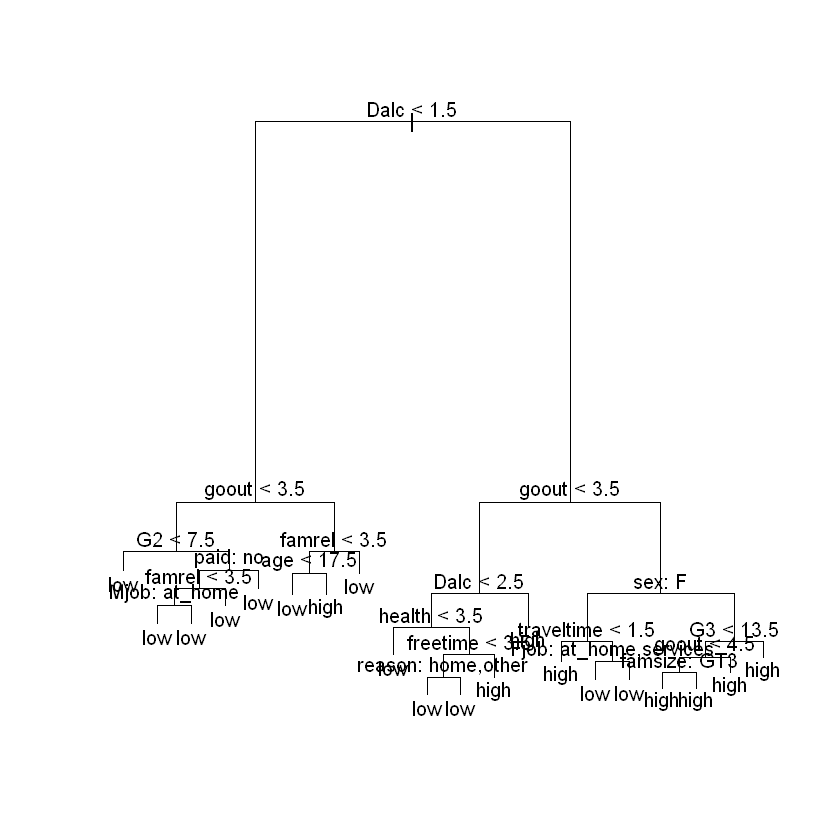

In [103]:
tree.class = tree(Walc∼., train_c)
summary(tree.class)

plot(tree.class)
text(tree.class ,pretty =0)

In [104]:
tree.pred = predict(tree.class ,test, type="class")
res = table(tree.pred, y.test_c)
res
cat("taux de mauvaise classification :", 1 - sum(diag(res))/149)

         y.test_c
tree.pred high low
     high   15  15
     low    12 107

taux de mauvaise classification : 0.1812081

Nous pouvons constater que nous obtenons un taux d'erreur assez correct. Cependant, l'arbre obtenu est assez compliqué, ce qui nuit à l'interprétabilité du résultat. Nous allons donc chercher à élager cet arbre pour le simplifier, en espérant en plus obtenir un meilleur taux de classification.

In [105]:
set.seed(2036125)
cv.tree.class =cv.tree(tree.class ,FUN=prune.misclass)
cv.tree.class

$size
[1] 20 11  8  6  5  3  1

$dev
[1]  76  74  75  76  75  74 108

$k
[1]      -Inf  0.000000  1.333333  1.500000  3.000000  4.000000 20.000000

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

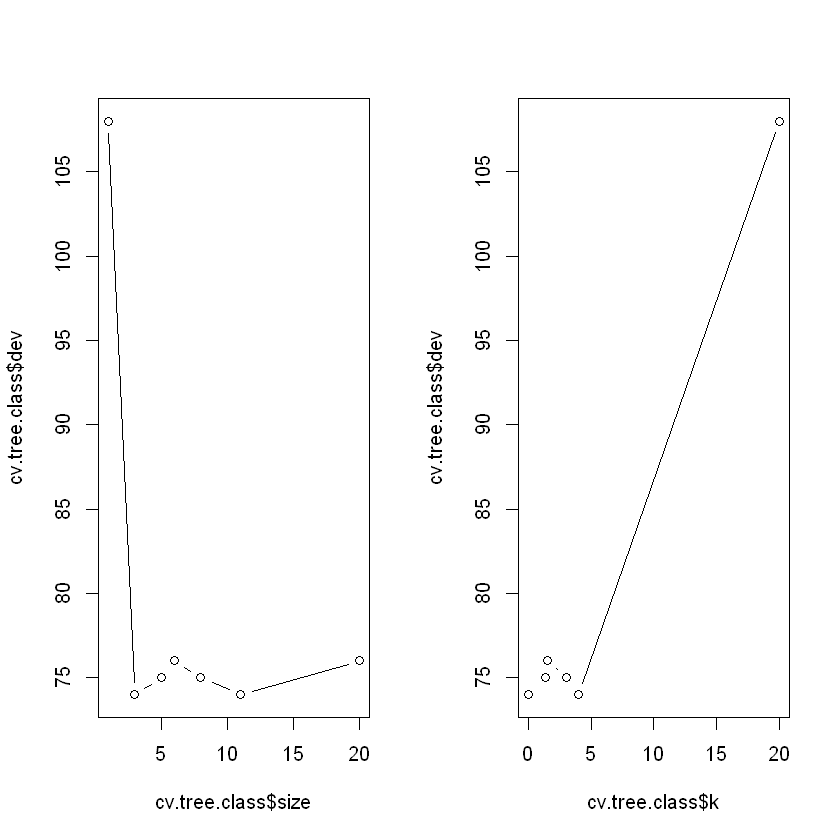

In [106]:
par(mfrow=c(1,2))
plot(cv.tree.class$size ,cv.tree.class$dev ,type="b")
plot(cv.tree.class$k ,cv.tree.class$dev ,type="b") 

En étudiant les graphiques ci dessus, on peut constater que nous devons choisir 3 noeuds terminaux.

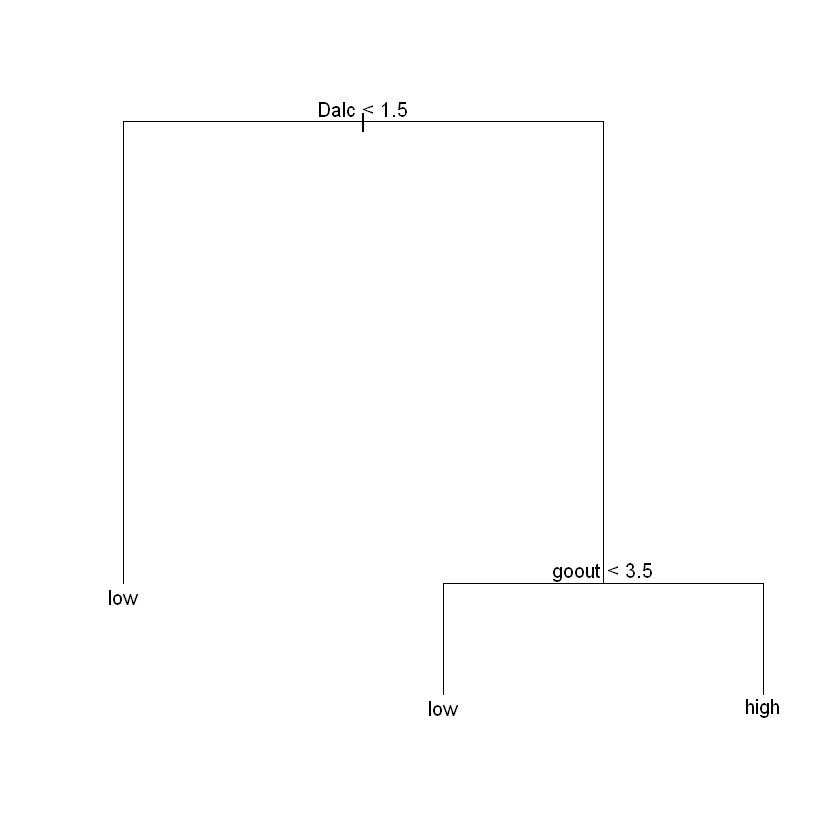

In [145]:
prune.class = prune.misclass (tree.class ,best=3)
plot(prune.class)
text(prune.class ,pretty =0)

In [146]:
tree.pred = predict(prune.class ,test, type="class")
res = table(tree.pred, y.test_c)

res
cat("taux de mauvaise classification :", 1 - sum(diag(res))/149)

         y.test_c
tree.pred high low
     high   12  12
     low    15 110

taux de mauvaise classification : 0.1812081

On constate que nous conservons le même taux d'erreur. cependant, ce taux est obtenu avec un modèle plus simple, ce qui facilte l'interprétation des réultats.

## Bagging

Nous allons maintenant essayer d'améliorer nos résultats en appliquant une méthode de bagging.

In [136]:
# calcul du modele
set.seed(2036125)
rf.Walc = randomForest(Walc~., data=train_c, mtry=dim(train_c)[2] - 1, importance=TRUE)

# estimations sur l'ensemble de test
tree.pred = predict(rf.Walc ,test, type="class")
res = table(tree.pred, y.test_c)

# affichage des résultats
rf.Walc
cat("taux de mauvaise classification sur les données de test:", 1 - sum(diag(res))/149)


Call:
 randomForest(formula = Walc ~ ., data = train_c, mtry = dim(train_c)[2] -      1, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 32

        OOB estimate of  error rate: 13.2%
Confusion matrix:
     high low class.error
high   63  42  0.40000000
low    24 371  0.06075949

taux de mauvaise classification sur les données de test: 0.1409396

On peut constater que le bagging nous permet d'améliorer nos résultats et d'obtenir un meilleur taux d'erreur.

## Random Forest

Nous allons maintenant appliquer la méthode des random forest. Pour commencer, nous allons fixer *mtry = 6* car cela correspond à la racine du nombre de variables.

In [109]:
# calcul du modele
set.seed(2036125)
rf.Walc = randomForest(Walc~., data=train_c, mtry=6, importance=TRUE)

# estimations sur l'ensemble de test
tree.pred = predict(rf.Walc ,test, type="class")
res = table(tree.pred, y.test_c)

# affichage des résultats
rf.Walc
cat("taux de mauvaise classification sur les données de test:", 1 - sum(diag(res))/149)


Call:
 randomForest(formula = Walc ~ ., data = train_c, mtry = 6, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 6

        OOB estimate of  error rate: 11.8%
Confusion matrix:
     high low class.error
high   56  49  0.46666667
low    10 385  0.02531646

taux de mauvaise classification sur les données de test: 0.1610738

On peut voir que cette méthode permet d'avoir de meilleurs résultats que les arbres classiques, mais cela ne permet pas pour l'instant d'être plus efficace que le bagging.  
Nous allons donc chercher à optimiser les choix des hyperparamètres *mtry* et *ntree*.

## Optimisation des hyperparametres

Pour choisir correctement *ntree*, nous allons fixer une valeur de *mtry*, et effectuer un grand nombre d'itérations pour voir quand le résultat du taux d'erreur OOB se stabilise.

In [148]:
# calcul du modele
set.seed(2036125)
rf.Walc = randomForest(Walc~., data=train_c, mtry=11, ntree = 4000, importance=TRUE)

# estimations sur l'ensemble de test
yhat.rf = predict(rf.Walc, newdata=test)
res = table(yhat.rf, y.test_c)

# affichage des résultats
cat("taux de mauvaise classification sur les données de test:", 1 - sum(diag(res))/149)

taux de mauvaise classification sur les données de test: 0.1409396

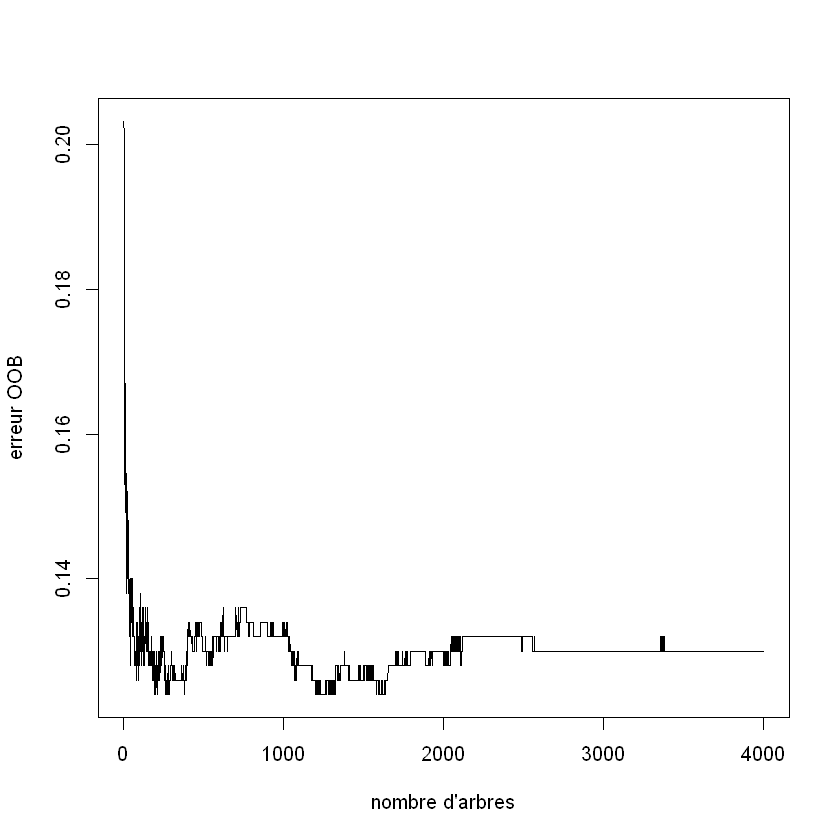

In [149]:
plot(rf.Walc$err.rate[,1], type = "l", xlab = "nombre d'arbres", ylab = "erreur OOB")

On constate que le résultat des random forest semble avoir convergé au bout de 2500/3000 itérations.    
<span style='color:red'>EST CE QUE LE RESULTAT DES RANDOM FOREST CONVERGE QUAND LE NOMBRE DE REPETITIONS TEND VERS L\'INFINI COMME POUR LE BAGGING?  
OU BIEN EST CE QU'ON A DU SURAPPRENTISSAGE?</span>

In [131]:
# initialisation des variables
v1 = 1
v2 = 15
nt = 3000
var_max = v1:v2
taux_OBB = matrix('numeric', ncol = v2-v1+1, nrow = nt)

for (i in 1:(v2-v1+1)){
    
    p = var_max[i]
    # calcul du modele
    set.seed(2036125)
    rf = randomForest(Walc~., data=train_c, mtry=p, ntree = nt, importance=TRUE)
    
    # taux d'erreur de classification
    taux_OBB[,i] = rf$err.rate[,1]
}

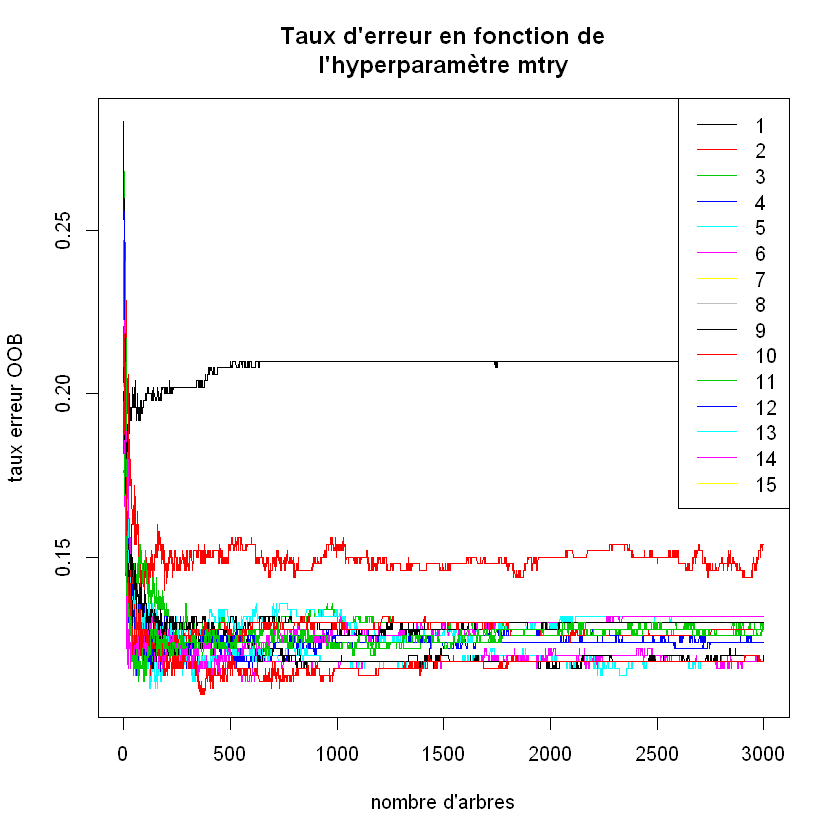

In [132]:
# Affichage
matplot(taux_OBB[1:nt,], type = "l", main="Taux d'erreur en fonction de\nl'hyperparamètre mtry",
        xlab = "nombre d'arbres", ylab = "taux erreur OOB", lty=1)
legend('topright', legend = var_max, col = var_max, lty=1)

In [133]:
 = which.min(taux_OBB[nt,])
cat('la valeur optimale de mtry est', mtry_opt)

la valeur optimale de mtry est 5

Nous allons maintenant réappliquer nos random forest avec les valeurs d'hyperparamètres trouvées précédemment

In [134]:
# calcul du modele
set.seed(2036125)
rf.Walc = randomForest(Walc~., data=train_c, mtry = mtry_opt, ntree = 2500, importance=TRUE)

# estimations sur l'ensemble de test
yhat.rf = predict(rf.Walc, newdata=test)
res = table(yhat.rf, y.test_c)

# affichage des résultats
rf.Walc
cat("taux de mauvaise classification sur les données de test:", 1 - sum(diag(res))/149)


Call:
 randomForest(formula = Walc ~ ., data = train_c, mtry = mtry_opt,      ntree = nt, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 3000
No. of variables tried at each split: 5

        OOB estimate of  error rate: 11.8%
Confusion matrix:
     high low class.error
high   53  52  0.49523810
low     7 388  0.01772152

taux de mauvaise classification sur les données de test: 0.1610738

On constate que cela n'améliore pas les résultats de la méthode des random forests

## Boosting

<span style='color:red'>TODO</span>
* Pour l'instant, il y a une erreur dans le boosting
* Essayer de faire varier les valeurs de *interaction.depth* et de *shrinkage* (qui vaut 0.2 par défaut)

In [160]:
# on convertit les valeurs en 0 et 1 pour la fonction gbm
train_c[, indWalc] = ifelse(train_c[, indWalc] == 'low', 0, 1)
y.test_c = ifelse(y.test_c == 'low', 0, 1)

In [165]:
# calcul du modele
set.seed(2036125)
boost.Walc = gbm(Walc~., data=train_c, distribution= "bernoulli",
                 n.trees=5000,interaction.depth=4)

# estimations sur l'ensemble de test
yhat.boost = predict(boost.Walc, newdata=test, n.trees=5000)
res = table(yhat.boost, y.test_c)

# affichage des résultats
boost.Walc
res
cat("taux de mauvaise classification sur les données de test:", 1 - sum(diag(res))/149)